In [21]:
from collections import Counter
import nltk
import pandas as pd
from emoticons import EmoticonDetector
import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim

import matplotlib.pyplot as plt
%matplotlib inline

# plotly configuration
plotly.offline.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [57]:
class Data_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["comment", "emotion", "date","url"])
            self.data = self.data[self.data["emotion"].isin(["positive", "negative"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["comment"],dtype={"comment":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["text"])
            not_null_id = 1 ^ pd.isnull(self.data["id"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

In [58]:
data = Data_Initialize()
data.initialize("data\\four-column500.csv")
data.processed_data.head(5)

,comment,emotion,date,url
0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,brabi orange pk l connexion ma t7ebech temchil...,negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,slm orange elyoum 3adet fourfi 900 ta3 7 jour ...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,N7eb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...


In [59]:
df = data.processed_data
neg = len(df[df["emotion"] == "negative"])
pos = len(df[df["emotion"] == "positive"])
dist = [
    graph_objs.Bar(
        x=["negative","positive"],
        y=[neg, pos],
)]


In [60]:
groupEmotion = df.groupby('emotion').size()
print(type(groupEmotion))
groupEmotion

<class 'pandas.core.series.Series'>


emotion
negative    262
positive    237
dtype: int64

<Container object of 2 artists>

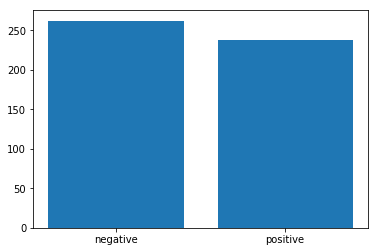

In [61]:
plt.bar(groupEmotion.index, groupEmotion)

In [62]:
#Every word is converted into a feature using a simplified bag of words model:
def words(stringIterable):
    lineStream = iter(stringIterable)
    for line in lineStream: #enumerate the lines
        for word in line.split(): #further break them down
            yield word

listepos = []
listeneg = []
for word in data.processed_data.comment:
    #print(word)
    for w in words([word]):
        #print(w)

SyntaxError: unexpected EOF while parsing (<ipython-input-62-22e5ce288b60>, line 13)

In [63]:
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "comment"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["comment"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "comment"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [64]:
class TwitterData_Cleansing(Data_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [65]:
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())
data.processed_data.head(10)

,comment,emotion,date,url
0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,brabi orange pk l connexion ma tebech temchili...,negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,slm orange elyoumadet fourfi ta jour tantli ma...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,Neb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...
5,حزين,negative,2018-01-08T19:15:36+0000,https://www.facebook.com/298166859034_10155991...
6,نسالكم ميغاا الله لا تربحكم انتم باش تربحوو ال...,negative,2018-01-02T19:11:40+0000,https://www.facebook.com/298166859034_10155976...
7,Problème de connexion avec les sites internati...,negative,2018-01-09T18:10:08+0000,https://www.facebook.com/298166859034_10155990...
8,bon orange pk la connexion tbch temchi ken fac...,negative,2018-01-02T20:47:32+0000,https://www.facebook.com/298166859034_10155976...
9,aslma orange belhy neb nareflach neetow barcha...,negative,2018-01-02T21:43:12+0000,https://www.facebook.com/298166859034_10155976...


In [67]:
words = Counter()
for idx in data.processed_data.index:
    words.update(data.processed_data.loc[idx, "comment"])
words.most_common(5)

TypeError: 'float' object is not iterable